# Getting Started with CTO

This is an entirely self-contained notebook comparing training data from our [CTO](https://chufangao.github.io/CTOD/)[1] label predictions against [TOP](https://github.com/futianfan/clinical-trial-outcome-prediction)[2] training labels, tested on the TOP test split.

[1] Gao, C., Pradeepkumar, J., Das, T., Thati, S., & Sun, J. (2024). Automatically Labeling Clinical Trial Outcomes: A Large-Scale Benchmark for Drug Development. arXiv preprint arXiv:2406.10292.

[2] Fu, T., Huang, K., Xiao, C., Glass, L. M., & Sun, J. (2022). Hint: Hierarchical interaction network for clinical-trial-outcome predictions. Patterns, 3(4).

# Loading in the datasets

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# First, let us get started
!git clone https://github.com/chufangao/CTOD.git
!git clone https://github.com/futianfan/clinical-trial-outcome-prediction.git
!wget https://huggingface.co/datasets/chufangao/CTO/resolve/main/CTTI.zip
CTTI_PATH = './CTTI.zip'

fatal: destination path 'CTOD' already exists and is not an empty directory.
fatal: destination path 'clinical-trial-outcome-prediction' already exists and is not an empty directory.
--2025-03-06 21:47:02--  https://huggingface.co/datasets/chufangao/CTO/resolve/main/CTTI.zip
Resolving huggingface.co (huggingface.co)... 3.167.112.38, 3.167.112.25, 3.167.112.45, ...
Connecting to huggingface.co (huggingface.co)|3.167.112.38|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/da/7f/da7f4412b646e319927d3efe09843fa4011826528566ace91f650c2b87e52687/fae177751917082e5d439755a26093d56fbd4002c1e89562ee7728ff80f6d06c?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27CTTI.zip%3B+filename%3D%22CTTI.zip%22%3B&response-content-type=application%2Fzip&Expires=1741301222&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MTMwMTIyMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL

In [ ]:
# # if you want to use the latest version of clinical trials instead, uncomment and run this cell
# !pip install selenium
# !python ./CTOD/download_ctti.py
# CTTI_PATH = './downloads/CTTI_new.zip'

In [ ]:
import pandas as pd
# Load clinical trial outcome labels from CTO
CTO_phase1_preds = pd.read_csv("https://huggingface.co/datasets/chufangao/CTO/raw/main/phase1_CTO_rf.csv")
CTO_phase2_preds = pd.read_csv("https://huggingface.co/datasets/chufangao/CTO/raw/main/phase2_CTO_rf.csv")
CTO_phase3_preds = pd.read_csv("https://huggingface.co/datasets/chufangao/CTO/raw/main/phase3_CTO_rf.csv")

In [ ]:
def load_all_studies_with_features(CTTI_PATH = './CTTI.zip'):
    import zipfile
    with zipfile.ZipFile(CTTI_PATH, 'r') as zip_ref:
        names = zip_ref.namelist()
        studies = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='studies.txt'][0]), sep='|')
        diseases = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='browse_conditions.txt'][0]), sep='|')
        interventions = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='interventions.txt'][0]), sep='|')
        criteria = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='eligibilities.txt'][0]), sep='|')
        designs = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='designs.txt'][0]), sep='|')

        # diseases = pd.read_csv(zip_ref.open('CTTI/browse_conditions.txt'), sep='|')
        # interventions = pd.read_csv(zip_ref.open('CTTI/interventions.txt'), sep='|')
        # criteria = pd.read_csv(zip_ref.open('CTTI/eligibilities.txt'), sep='|')
        # designs = pd.read_csv(zip_ref.open('CTTI/designs.txt'), sep='|')

    # diseases = pd.read_csv(os.path.join(CTTI_PATH, 'browse_conditions.txt'), sep='|')
    diseases = diseases.groupby('nct_id')['downcase_mesh_term'].apply(lambda x: ' '.join(list(x))).reset_index().rename(columns={'downcase_mesh_term': 'diseases'})
    diseases.fillna('', inplace=True)

    # interventions = pd.read_csv(os.path.join(CTTI_PATH, 'interventions.txt'), sep='|')
    interventions = interventions.dropna(subset=['name'])
    interventions['name'] = interventions['name'].str.lower()
    interventions = interventions.groupby('nct_id')['name'].apply(lambda x: ' '.join(list(x))).reset_index().rename(columns={'name': 'interventions'})
    interventions.fillna('', inplace=True)

    # criteria = pd.read_csv(os.path.join(CTTI_PATH, 'eligibilities.txt'), sep='|')[['nct_id', 'criteria']]
    criteria = criteria.dropna(subset=['criteria'])
    criteria.drop_duplicates(subset=['nct_id'], inplace=True)
    criteria['criteria'] = criteria['criteria'].str.lower()
    criteria.fillna('', inplace=True)

    # designs = pd.read_csv(os.path.join(CTTI_PATH, 'designs.txt'), sep='|')
    designs = designs.fillna('')
    designs['design'] = designs['allocation'] + ' ' + designs['intervention_model'] + ' ' + designs['observational_model'] + ' ' + designs['primary_purpose'] + ' ' + designs['time_perspective'] + ' ' + designs['masking']
    designs['design'] = designs['design'].str.lower()
    designs = designs[['nct_id', 'design']]
    designs.drop_duplicates(subset=['nct_id'], inplace=True)
    designs.fillna('', inplace=True)

    # studies = pd.read_csv(os.path.join(CTTI_PATH, 'studies.txt'), sep='|')
    studies.dropna(subset=['completion_date'], inplace=True)
    studies['year'] = studies['completion_date'].apply(lambda x: int(x.split('-')[0]))

    studies = studies.merge(diseases, on='nct_id', how='left')
    studies = studies.merge(interventions, on='nct_id', how='left')
    studies = studies.merge(criteria, on='nct_id', how='left')
    studies = studies.merge(designs, on='nct_id', how='left')
    studies['features'] = studies['phase'] + ' '  + studies['diseases'] + ' '  + studies['interventions'] + ' ' + studies['design'] + ' ' + studies['criteria']
    studies = studies[studies['features'].str.len() > 0]
    del diseases, interventions, criteria, designs
    return studies

studies_with_features = load_all_studies_with_features(CTTI_PATH)


In [ ]:
studies_with_features.shape

(167012, 89)

# Visualize All Features

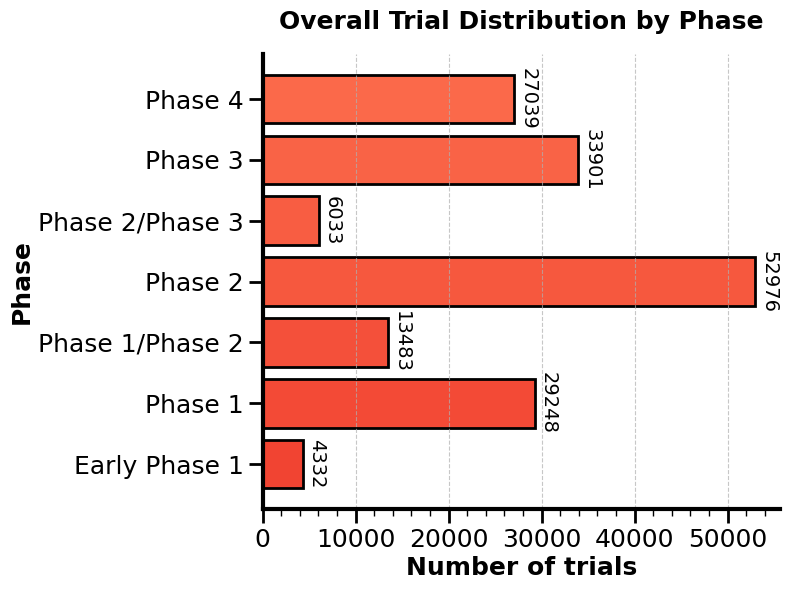

In [ ]:
# Phase Distribution
from CTOD.tutorials.vis_utils import plot_phase_distribution
plot_phase_distribution(studies_with_features,'Overall Trial Distribution by Phase')

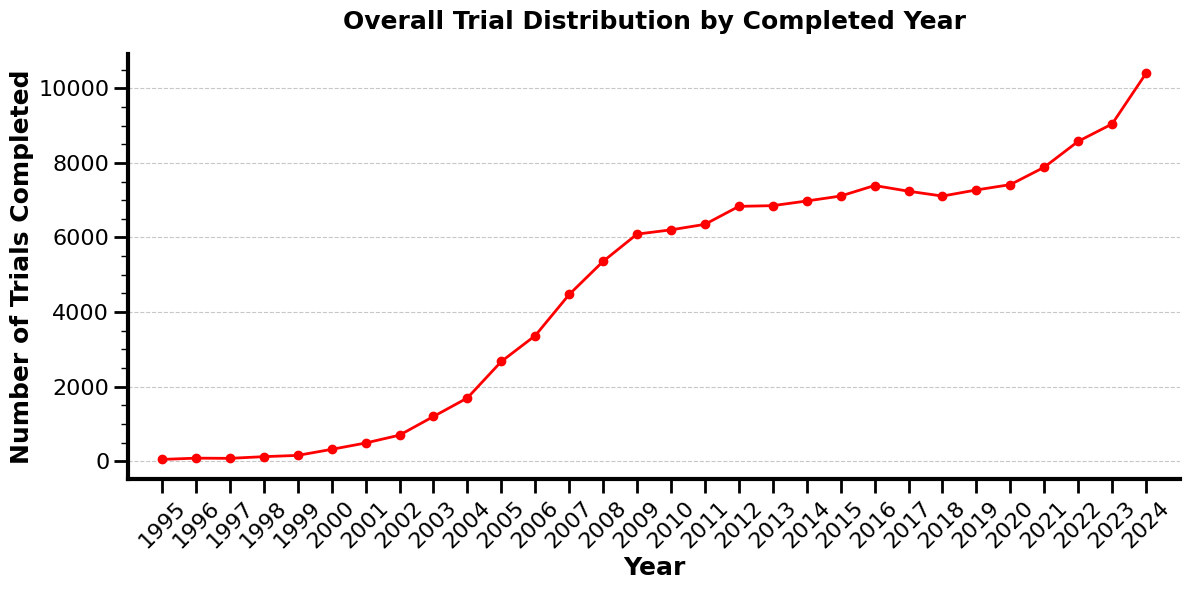

In [ ]:
# Trial Distribution by Completed Year
from CTOD.tutorials.vis_utils import plot_completed_year_distribution
plot_completed_year_distribution(studies_with_features,'Overall Trial Distribution by Completed Year',thresh_timestamp = '2025-01-01')

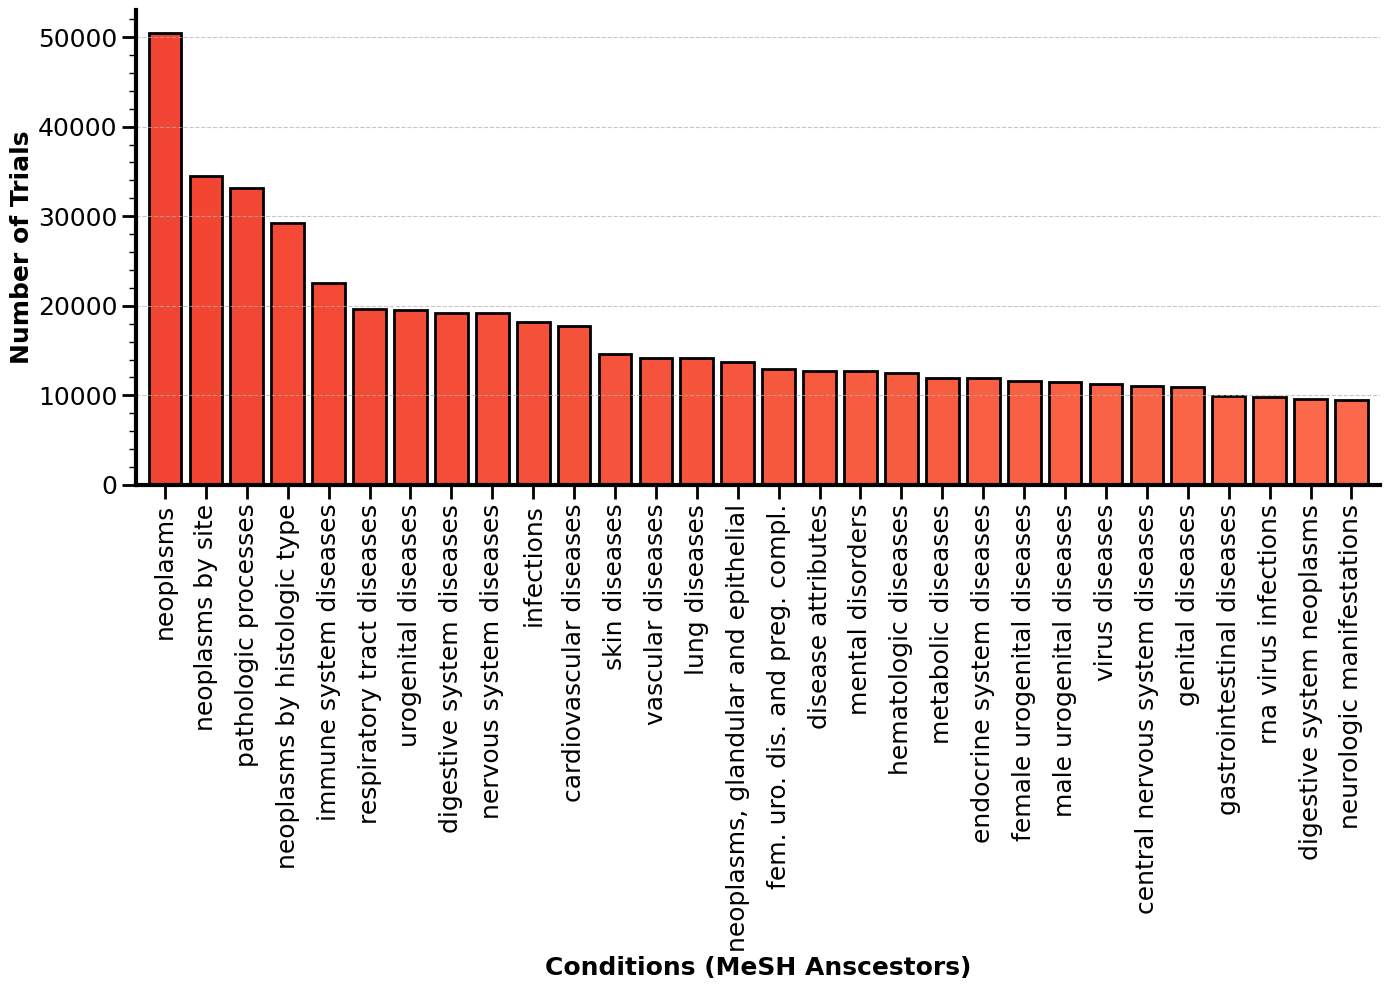

In [ ]:
# Trial Distribution by Top K Conditions
from CTOD.tutorials.vis_utils import plot_top_K_condition_distribution
K=30
plot_top_K_condition_distribution(CTTI_PATH,studies_with_features,f'Frequency of Top {K} Conditions',K = K)

# Prepare Data for Training






























In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import os
import glob
import zipfile

train_data_mode = 'CTO' # in ['CTO', 'TOP']

# test on supervised TOP labels
test_df = pd.concat((pd.read_csv(f) for f in glob.glob("./clinical-trial-outcome-prediction/data/phase*test.csv")))
test_df = test_df.rename(columns={'nctid': 'nct_id'})

if train_data_mode == 'TOP':
    train_df = pd.concat([pd.read_csv(f) for f in glob.glob("./clinical-trial-outcome-prediction/data/phase*train.csv") + glob.glob("./clinical-trial-outcome-prediction/data/phase*valid.csv")])
    train_df = train_df.rename(columns={'nctid': 'nct_id'})
elif train_data_mode == 'CTO':
    # concatenate
    studies_with_features['completion_date'] = pd.to_datetime(studies_with_features['completion_date'])

    CTO_preds = pd.concat([CTO_phase1_preds[['nct_id', 'pred']], CTO_phase2_preds[['nct_id', 'pred']], CTO_phase3_preds[['nct_id', 'pred']]])
    CTO_preds = CTO_preds.rename(columns={'pred': 'label'})
    CTO_preds = pd.merge(CTO_preds, studies_with_features[['nct_id', 'completion_date']], on='nct_id', how='left')
    CTO_preds.dropna(inplace=True)
    train_df = CTO_preds[CTO_preds['completion_date'] < '2015-01-01']

train_features = train_df.merge(studies_with_features[['nct_id', 'features']], on='nct_id', how='left')
train_features.dropna(subset='features', inplace=True)

test_features = test_df.merge(studies_with_features[['nct_id', 'features']], on='nct_id', how='left')
test_features.dropna(subset='features', inplace=True)

# ============ preprocess by filling NAs and dropping duplicates ============
tfidf = TfidfVectorizer(max_features=2048, stop_words='english')
X_train = tfidf.fit_transform(train_features['features'])
X_test = tfidf.transform(test_features['features'])

In [ ]:
print(test_features['features'])

0       PHASE1/PHASE2 neoplasms, connective and soft t...
1       PHASE1 heart diseases cardiovascular diseases ...
2       PHASE1 respiratory tract neoplasms thoracic ne...
3       PHASE1 neoplasms by histologic type neoplasms ...
4       PHASE1 alcohol-related disorders substance-rel...
                              ...                        
3421    PHASE3 pain neurologic manifestations acute pa...
3423    PHASE3 skin diseases skin diseases, genetic ge...
3424    PHASE2/PHASE3 muscular disorders, atrophic mus...
3425    PHASE3 connective tissue diseases autoimmune d...
3426    PHASE3 disease attributes pathologic processes...
Name: features, Length: 3250, dtype: object


# Running evaluation of machine learning baselines

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
# from xgboost import XGBClassifier # pip install xgboost
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, average_precision_score, roc_auc_score

def bootstrap_eval(y_true, y_pred, y_prob, num_samples=100):
    f1s = []
    aps = []
    rocs = []
    for _ in range(num_samples):
        indices = np.random.choice(len(y_true), len(y_true), replace=True)
        f1s.append(f1_score(y_true[indices], y_pred[indices]))
        aps.append(average_precision_score(y_true[indices], y_prob[indices]))
        rocs.append(roc_auc_score(y_true[indices], y_prob[indices]))
    return np.mean(f1s), np.std(f1s), np.mean(aps), np.std(aps), np.mean(rocs), np.std(rocs)

print(train_data_mode)
print(f'Model, Phase, F1, AP, ROC')
# for model_name in ['svm', 'xgboost', 'mlp', 'rf', 'lr', ]:
for model_name in ['svm', 'lr']: # use fastest models for testing
    if model_name == 'rf':
        model = RandomForestClassifier(n_estimators=300, random_state=0, max_depth=10, n_jobs=4)
    elif model_name == 'lr':
        model = LogisticRegression(max_iter=1000, random_state=0)
    elif model_name == 'svm':
        model = LinearSVC(dual="auto", max_iter=10000, random_state=0)
        model = CalibratedClassifierCV(model)
        # model = SVC(kernel='linear', probability=True, random_state=0) # performs worse than the above
    # elif model_name == 'xgboost':
    #     model = XGBClassifier(n_estimators=300, random_state=0, max_depth=10, n_jobs=4)
    elif model_name == 'mlp':
        model = MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=2000, random_state=0)
    else:
        raise ValueError('Unknown model name')

    model.fit(X_train, train_features['label'])
    test_features['pred'] = model.predict(X_test)
    test_features['prob'] = model.predict_proba(X_test)[:, 1]

    for phase in ['1', '2', '3']:
        test_df_subset = test_features[test_features['phase'].str.lower().str.contains(phase)]
        f1_mean, f1_std, ap_mean, ap_std, roc_mean, roc_std = bootstrap_eval(test_df_subset['label'].values, test_df_subset['pred'].values, test_df_subset['prob'].values)
        print(f"{model_name}, {phase}, {f1_mean:.3f}, {f1_std:.3f}, {ap_mean:.3f}, {ap_std:.3f}, {roc_mean:.3f}, {roc_std:.3f}")

CTO
Model, Phase, F1, AP, ROC
svm, 1, 0.733, 0.014, 0.686, 0.027, 0.632, 0.023
svm, 2, 0.725, 0.009, 0.652, 0.017, 0.620, 0.012
svm, 3, 0.848, 0.008, 0.806, 0.015, 0.626, 0.018
lr, 1, 0.732, 0.017, 0.696, 0.022, 0.649, 0.020
lr, 2, 0.725, 0.011, 0.667, 0.017, 0.632, 0.013
lr, 3, 0.850, 0.009, 0.815, 0.018, 0.639, 0.018


```
CTO
Phase, Model, F1, AP, ROC
1, svm, 0.731, 0.017, 0.685, 0.025, 0.634, 0.020
2, svm, 0.724, 0.010, 0.652, 0.016, 0.619, 0.012
3, svm, 0.849, 0.009, 0.808, 0.015, 0.628, 0.017
1, lr, 0.733, 0.014, 0.695, 0.023, 0.651, 0.020
2, lr, 0.727, 0.010, 0.669, 0.016, 0.631, 0.012
3, lr, 0.849, 0.009, 0.813, 0.017, 0.638, 0.018
```



```
TOP
Phase, Model, F1, AP, ROC
1, svm, 0.617, 0.018, 0.638, 0.025, 0.559, 0.019
2, svm, 0.660, 0.013, 0.656, 0.016, 0.614, 0.013
3, svm, 0.810, 0.009, 0.865, 0.011, 0.697, 0.015
1, lr, 0.642, 0.022, 0.682, 0.028, 0.613, 0.022
2, lr, 0.676, 0.011, 0.693, 0.015, 0.645, 0.012
3, lr, 0.832, 0.010, 0.882, 0.012, 0.728, 0.016
```

